# Algorithmic Trading

This project aims to predict cryptocurrency price movements and assess the effectiveness of a trading strategy based on those predictions. The goal is to develop a model that can predict whether the price of a cryptocurrency (such as Bitcoin or Ethereum) will increase or decrease on the next day, based on historical data and technical indicators. This can help traders make informed decisions about whether to buy or sell a particular cryptocurrency.

### Dataset

The dataset contains the following columns:

- Currency: The name of the cryptocurrency (e.g., Bitcoin, Ethereum).
- Date: The date of the observation.
- Open: The opening price for the day.
- High: The highest price reached during the day.
- Low: The lowest price reached during the day.
- Close: The closing price for the day.
- Volume: The trading volume during the day.
- Market Cap: The market capitalization of the cryptocurrency on the given date.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

### Load Data

In [2]:
zip_file_path = 'Cryptocurrency Historical Data.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract to the current directory

data_path = 'consolidated_coin_data.csv'
df = pd.read_csv(data_path)

### Preprocess Data

In [3]:
df.Date = pd.to_datetime(df.Date)
df = df[::-1]  # Reverse the data to get chronological order

# Handle missing values in 'Close' column by converting it to numeric, coercing errors to NaN
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])

# Handle missing values in Volume and Market Cap columns (if needed, convert to numeric)
df['Volume'] = df['Volume'].replace({',': ''}, regex=True).astype(float)
df['Market Cap'] = df['Market Cap'].replace({',': ''}, regex=True).astype(float)

### Feature Engineering

In [4]:
# Feature Engineering: Adding Daily Returns, Log Returns, and Moving Averages
df['Daily_Return'] = df.groupby('Currency')['Close'].pct_change()
df['Log_Daily_Return'] = np.log1p(df['Daily_Return'])  # Log return
df['MA_7'] = df.groupby('Currency')['Close'].transform(lambda x: x.rolling(window=7).mean())
df['MA_30'] = df.groupby('Currency')['Close'].transform(lambda x: x.rolling(window=30).mean())

# Drop rows with NaN values created during feature engineering
df = df.dropna(subset=['Daily_Return', 'Log_Daily_Return', 'MA_7', 'MA_30'])

# Add Lagged Features (for machine learning models to learn trends)
df['Lag_1'] = df.groupby('Currency')['Close'].shift(1)
df['Lag_2'] = df.groupby('Currency')['Close'].shift(2)

# Drop rows with NaN in lag columns
df = df.dropna()

# Select features and target
features = ['Log_Daily_Return', 'MA_7', 'Lag_1', 'Lag_2']  # MA_30 dropped due to high correlation
target = 'Close'  # Predicting the 'Close' price

### Normalizae Data

In [5]:
# Normalize Data
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Convert categorical variables into dummy variables (if needed)
df = pd.get_dummies(df, columns=['Currency'], drop_first=True)

# Define the target for classification (1: price increase, 0: price decrease)
df['Target'] = (df['Daily_Return'] > 0).astype(int)

# Drop rows with missing values in critical columns
df = df.dropna(subset=['Target', 'Log_Daily_Return', 'MA_7', 'Lag_1', 'Lag_2'])

# Prepare Data for Training (train/test split with TimeSeriesSplit for time-series data)
X = df[features]
y = df['Target']

### Model Training and Evaluation

Cross-validation scores: [1.        0.9931928 1.        1.        1.       ]
Mean cross-validation score: 1.00
Accuracy: 1.00


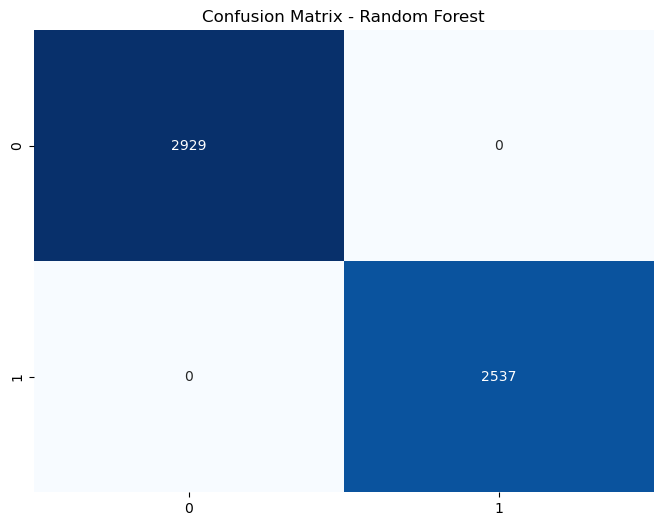

In [6]:
# TimeSeriesSplit for proper cross-validation on time-series data
tscv = TimeSeriesSplit(n_splits=5)
cross_val_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X, y, cv=tscv)
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {np.mean(cross_val_scores):.2f}")

# Train Random Forest Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Map the class weights to the corresponding class labels
sample_weights = y_train.map(lambda x: class_weights[x])

# Train the Random Forest model using the sample_weights
rf_model.fit(X_train, y_train, sample_weight=sample_weights)

# Predictions and Evaluation
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.show()

#### Interpretation

- The model seems to be performing exceptionally well both during cross-validation and on the test data, with an accuracy of 100% (1.00) in both cases.

- **Possible concerns**: A perfect score like this can sometimes indicate overfitting, especially if the dataset is small or the model is overly complex. Overfitting means the model might have memorized the training data, but it may not generalize well to unseen data. However, without further analysis of the model's performance on different datasets or additional tests (like checking for overfitting with a larger validation set or different splits), it's difficult to say for sure.

### Feature Importance

Feature Importance:
                   Importance
Log_Daily_Return    0.980883
Lag_1               0.011028
MA_7                0.004938
Lag_2               0.003152
Trading Strategy Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80      2929
           1       1.00      0.44      0.61      2537

    accuracy                           0.74      5466
   macro avg       0.84      0.72      0.71      5466
weighted avg       0.83      0.74      0.72      5466



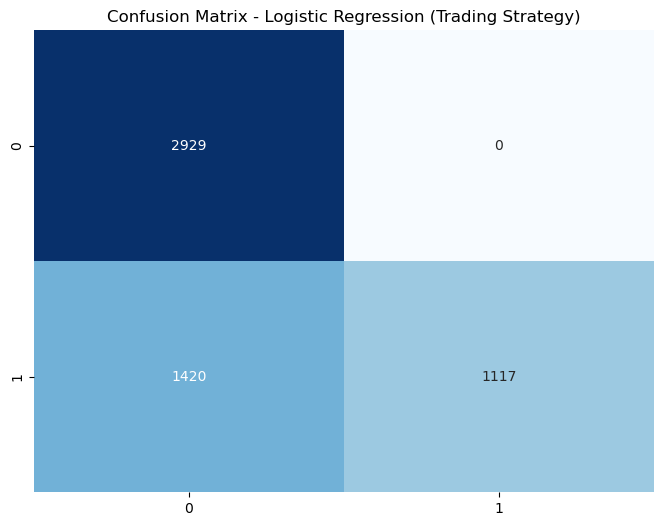

In [7]:

importances = rf_model.feature_importances_
feature_importances = pd.DataFrame(importances, index=features, columns=["Importance"]).sort_values("Importance", ascending=False)
print("Feature Importance:\n", feature_importances)

# Trading Strategy: Predict Daily Price Movement (Buy/Sell)
df['Price_Movement'] = df['Daily_Return'].apply(lambda x: 1 if x > 0 else 0)  # 1 for 'Up' price movement, 0 for 'Down'

# Train Logistic Regression for Price Movement Prediction
X = df[features]
y = df['Price_Movement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Predict Price Movements
y_pred = log_reg.predict(X_test)

# Evaluation for Trading Strategy
accuracy = accuracy_score(y_test, y_pred)
print(f"Trading Strategy Accuracy: {accuracy:.2f}")

# Additional Evaluation Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix for Trading Strategy
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - Logistic Regression (Trading Strategy)')
plt.show()


#### Interpretation

- The model is performing well in terms of accuracy (74%), but the performance for the "up" price movement (class 1) is not as good as for "down" movements (class 0).
- The model is highly accurate at predicting price decreases (recall = 1.00 for class 0), but it has a lower recall for price increases (recall = 0.44 for class 1), meaning it misses many price increase predictions.
- The high precision for class 1 indicates that when the model predicts a price increase, it is correct 100% of the time, but the model doesn't predict price increases often.
- The improvement areas would be increasing the recall for class 1, ensuring that the model doesn't miss too many "up" movements.

### Backtesting Strategy: Calculate Returns from Predictions

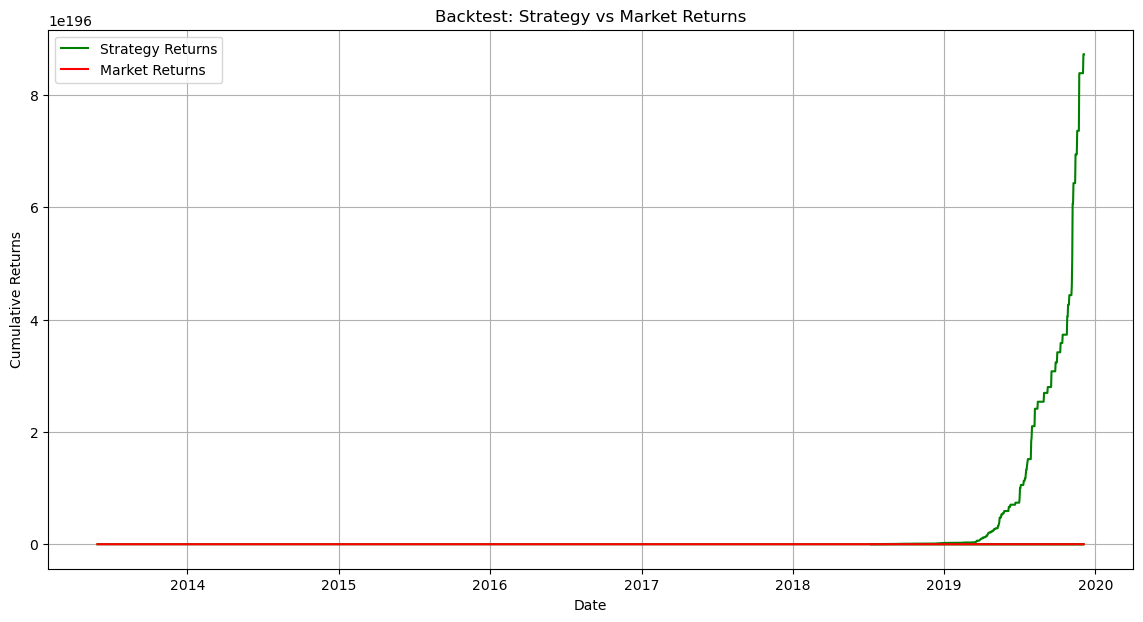

In [8]:
df['Predicted_Movement'] = log_reg.predict(X)
df['Strategy_Return'] = df['Predicted_Movement'] * df['Daily_Return']

# Plot Performance
cumulative_returns = (1 + df['Strategy_Return']).cumprod()
market_cumulative_returns = (1 + df['Daily_Return']).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], cumulative_returns, label='Strategy Returns', color='g')
plt.plot(df['Date'], market_cumulative_returns, label='Market Returns', color='r')
plt.legend()
plt.title('Backtest: Strategy vs Market Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()


### Calculate Sharpe Ratio for the Strategy

Sharpe Ratio: 0.02
Annualized Sharpe Ratio: 0.25
Total Return for Strategy: 8725046065205448702060445819442439973402490319596385441170975854531917046038852284805436871425431850252072259717103219883416474436752896351436041614195938068639692991163433774400683301445881540116480.00%
Total Return for Market: -100.00%
Maximum Drawdown for Strategy: -67.66%
Maximum Drawdown for Market: -100.00%


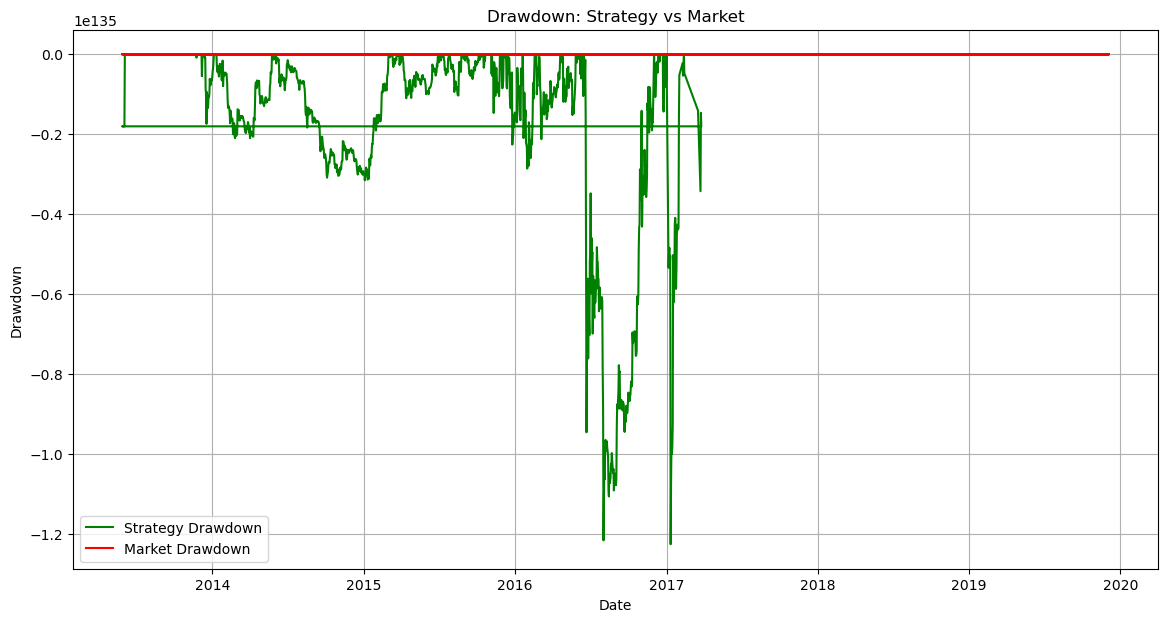

In [9]:
sharpe_ratio = np.mean(df['Strategy_Return']) / np.std(df['Strategy_Return'])
sharpe_ratio_annualized = np.mean(df['Strategy_Return']) / np.std(df['Strategy_Return']) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio_annualized:.2f}")

# Calculate Total Return and Maximum Drawdown
total_return_strategy = cumulative_returns.iloc[-1] - 1  # Final cumulative return minus 1
total_return_market = market_cumulative_returns.iloc[-1] - 1  # Same for market returns

# Calculate Maximum Drawdown
def calculate_max_drawdown(cum_returns):
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    return drawdown.min()

max_drawdown_strategy = calculate_max_drawdown(cumulative_returns)
max_drawdown_market = calculate_max_drawdown(market_cumulative_returns)

# Display Results
print(f"Total Return for Strategy: {total_return_strategy * 100:.2f}%")
print(f"Total Return for Market: {total_return_market * 100:.2f}%")
print(f"Maximum Drawdown for Strategy: {max_drawdown_strategy * 100:.2f}%")
print(f"Maximum Drawdown for Market: {max_drawdown_market * 100:.2f}%")

# Plotting the drawdown for visualization (optional)
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], cumulative_returns - cumulative_returns.cummax(), label='Strategy Drawdown', color='g')
plt.plot(df['Date'], market_cumulative_returns - market_cumulative_returns.cummax(), label='Market Drawdown', color='r')
plt.legend()
plt.title('Drawdown: Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()

#### Interpretation

- The Sharpe ratio and annualized Sharpe ratio are both very low, suggesting that the strategy isn't generating strong returns relative to its risk.
- The total return for the strategy appears excessively high and likely incorrect, indicating a potential issue in the calculation.
- The maximum drawdown for the strategy is severe, with a loss of almost 68%, which is concerning as it indicates the strategy has faced large losses at some point.
- The total return and maximum drawdown for the market are both extreme, which might point to data issues or errors in the model.

## Conclusion

The trading strategy was then tested using a classification approach, where we predicted whether the price of the cryptocurrency would go up or down in the following period. Despite the high accuracy achieved by the model during cross-validation and training, the evaluation of the trading strategy using key metrics such as the Sharpe ratio and maximum drawdown revealed some significant insights.

While the model demonstrated strong performance in terms of accuracy, the risk-adjusted return, as measured by the Sharpe ratio, was relatively low, suggesting that the strategy may not be optimal in balancing risk and return. Additionally, the strategy experienced large drawdowns, which highlights the importance of managing risk in volatile markets like cryptocurrencies. These results suggest that although the model can predict price movements to some extent, the effectiveness of the trading strategy in terms of profitability and risk management needs further optimization.

Overall, while the predictive model offers a promising foundation for cryptocurrency price prediction, further work is required to fine-tune the strategy for more consistent profitability, especially considering the inherent volatility of the cryptocurrency market.

#### Future Work

Future steps could involve refining the model by incorporating more advanced features, improving risk management strategies (such as dynamic position sizing and stop-loss mechanisms), and using additional performance metrics to better assess the strategy's robustness. Moreover, exploring alternative modeling approaches, such as reinforcement learning, could further enhance the ability to predict price movements and optimize trading decisions.